<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/-K%5E3_L%5E3_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# ======================
# 0. Global config
# ======================
SEED = 42
ep = 100        # pretrain epochs on K^3
probe_ep = 100  # probe epochs on TL tasks
dense_num = [32, 16, 8, 4]

np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

# ======================
# 1. Data
# ======================
n = 1000
noise_scale = 0.05

# K-intensive: K ~ U(0,1), L = 0
K = np.random.rand(n, 1)
L0 = np.zeros((n, 1))
X_K = np.hstack([K, L0])

# L-intensive: K = 0, L ~ U(0,1)
K0 = np.zeros((n, 1))
L = np.random.rand(n, 1)
X_L = np.hstack([K0, L])

# Targets with noise
y1 = K**3  + np.random.normal(0, noise_scale, size=(n, 1))   #  K^3
y2 = -K**3 + np.random.normal(0, noise_scale, size=(n, 1))   # -K^3
y3 = L**3  + np.random.normal(0, noise_scale, size=(n, 1))   #  L^3

# Cast to float32 for Keras
X_K = X_K.astype("float32")
X_L = X_L.astype("float32")
y1  = y1.astype("float32")
y2  = y2.astype("float32")
y3  = y3.astype("float32")

# For plotting: sort by K and by L
K_1d = X_K[:, 0]
order_K = np.argsort(K_1d)
K_sorted = K_1d[order_K]
y1_sorted = y1[order_K, 0]
y2_sorted = y2[order_K, 0]

L_1d = X_L[:, 1]
order_L = np.argsort(L_1d)
L_sorted = L_1d[order_L]
y3_sorted = y3[order_L, 0]


# ======================
# 2. Model builders
# ======================
def build_full_model():
    inp = Input(shape=(2,), name='input_full')
    h1 = Dense(dense_num[0], activation='relu',
               kernel_initializer='he_normal', name='dense8_1')(inp)
    h2 = Dense(dense_num[1], activation='relu',
               kernel_initializer='he_normal', name='dense8_2')(h1)
    h3 = Dense(dense_num[2], activation='relu',
               kernel_initializer='he_normal', name='dense8_3')(h2)
    h4 = Dense(dense_num[3], activation='relu',
               kernel_initializer='he_normal', name='dense8_4')(h3)
    out = Dense(1, activation='linear', name='out')(h4)

    model = Model(inputs=inp, outputs=out, name='FullModel_8_8_8_4_1')
    model.compile(optimizer='adam', loss='mse')
    return model


def build_probe_at(backbone_model, stop_layer_name, head_name):
    """Attach a linear head on top of frozen backbone at given layer."""
    frozen_out = backbone_model.get_layer(stop_layer_name).output
    head = Dense(1, activation='linear', name=head_name)(frozen_out)
    probe = Model(inputs=backbone_model.input,
                  outputs=head,
                  name=f"Probe_{head_name}")
    probe.compile(optimizer='adam', loss='mse')
    return probe


# ======================
# 3. Pretrain on K^3 (y1)
# ======================
full_model = build_full_model()
full_model.fit(X_K, y1, epochs=ep, batch_size=32, verbose=0)
full_model.summary()

# Backbone: clone + copy weights + freeze hidden layers
backbone = tf.keras.models.clone_model(full_model)
_ = backbone(tf.zeros((1, 2)))  # build
backbone.set_weights(full_model.get_weights())

for lyr in backbone.layers:
    if lyr.name.startswith('dense8_'):
        lyr.trainable = False


# ======================
# 4. Build probes (for each layer, we build two heads)
#    - Task Kneg: X_K -> y2  (−K^3)
#    - Task Lcube: X_L -> y3 ( L^3)
# ======================
layer_names = [
    #"input_full",
    "dense8_1",
    "dense8_2",
    "dense8_3",
    "dense8_4",
]

probes_Kneg = {}
probes_Lcube = {}

for lname in layer_names:
    probes_Kneg[lname] = build_probe_at(backbone, lname, f"headK_{lname}")
    probes_Lcube[lname] = build_probe_at(backbone, lname, f"headL_{lname}")


# ======================
# 5. Train probes on their tasks
# ======================
for lname in layer_names:
    print(f"\n=== Training probes at layer: {lname} ===")
    print("Task Kneg: X_K -> -K^3")
    probes_Kneg[lname].fit(X_K, y2, epochs=probe_ep, batch_size=32, verbose=0)

    print("Task Lcube: X_L -> L^3")
    probes_Lcube[lname].fit(X_L, y3, epochs=probe_ep, batch_size=32, verbose=0)


# ======================
# 6. Plotting utilities
# ======================
def plot_1d_probe_pair(model_K, model_L,
                       X_K, y2, order_K, K_sorted, y2_sorted,
                       X_L, y3, order_L, L_sorted, y3_sorted,
                       layer_name):
    """Side-by-side plots for -K^3 and L^3 at the same layer."""

    # ----- architecture string: 2 -> 8 -> 1, 2 -> 8 -> 8 -> 1, ... -----
    def arch_from_layer(name):
        if name == "input_full":
            return "2 → 1"
        if name.startswith("dense8_"):
            idx = int(name.split("_")[1])          # 1,2,3,4
            hidden = " → ".join(str(dense_num[i])  # dense_num는 전역 리스트
                                 for i in range(idx))
            return f"2 → {hidden} → 1"
        return name

    arch_str = arch_from_layer(layer_name)

    # ---- Task 1: -K^3 ----
    y_hat_K = model_K.predict(X_K, verbose=0)[:, 0]
    y_hat_K_sorted = y_hat_K[order_K]
    mse_K = np.mean((y_hat_K - y2[:, 0])**2)

    # ---- Task 2: L^3 ----
    y_hat_L = model_L.predict(X_L, verbose=0)[:, 0]
    y_hat_L_sorted = y_hat_L[order_L]
    mse_L = np.mean((y_hat_L - y3[:, 0])**2)

    print(f"[{layer_name}] ({arch_str}) -K^3 MSE: {mse_K:.6f}")
    print(f"[{layer_name}] ({arch_str})  L^3 MSE: {mse_L:.6f}")

    # ---- Side-by-side figure: 세로 길이 키움 ----
    fig, axes = plt.subplots(1, 2, figsize=(11, 5.5), sharey=True)
    fig.suptitle(f"{arch_str}", fontsize=14)

    # (a) -K^3
    ax1 = axes[0]
    ax1.scatter(K_sorted, y2_sorted,
                s=8, alpha=0.3, c='0.6', label='data: -K^3')
    ax1.plot(K_sorted, y_hat_K_sorted,
             'k-', linewidth=2, label='probe pred')
    ax1.set_xlabel('K')
    ax1.set_ylabel('prediction')
    ax1.set_title(f"-K^3  (MSE={mse_K:.4f})")
    ax1.grid(True, color='0.8', linestyle=':')
    ax1.legend()

    # (b) L^3
    ax2 = axes[1]
    ax2.scatter(L_sorted, y3_sorted,
                s=8, alpha=0.3, c='0.6', label='data: L^3')
    ax2.plot(L_sorted, y_hat_L_sorted,
             'k-', linewidth=2, label='probe pred')
    ax2.set_xlabel('L')
    ax2.set_title(f"L^3  (MSE={mse_L:.4f})")
    ax2.grid(True, color='0.8', linestyle=':')
    ax2.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()


Model: "FullModel_8_8_8_4_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_full (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense8_1 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense8_2 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense8_3 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense8_4 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,405 (9.40 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,604 (6.27 KB)


=== Training probes at layer: dense8_1 ===
Task Kneg: X_K -> -K^3
Task Lcube: X_L -> L^3

=== Training probes at layer: dense8_2 ===
Task Kneg: X_K -> -K^3
Task Lcube: X_L -> L^3

=== Training probes at layer: dense8_3 ===
Task Kneg: X_K -> -K^3
Task Lcube: X_L -> L^3

=== Training probes at layer: dense8_4 ===
Task Kneg: X_K -> -K^3
Task Lcube: X_L -> L^3



######## Layer: dense8_1 ########
[dense8_1] (2 → 32 → 1) -K^3 MSE: 0.006787
[dense8_1] (2 → 32 → 1)  L^3 MSE: 0.010268


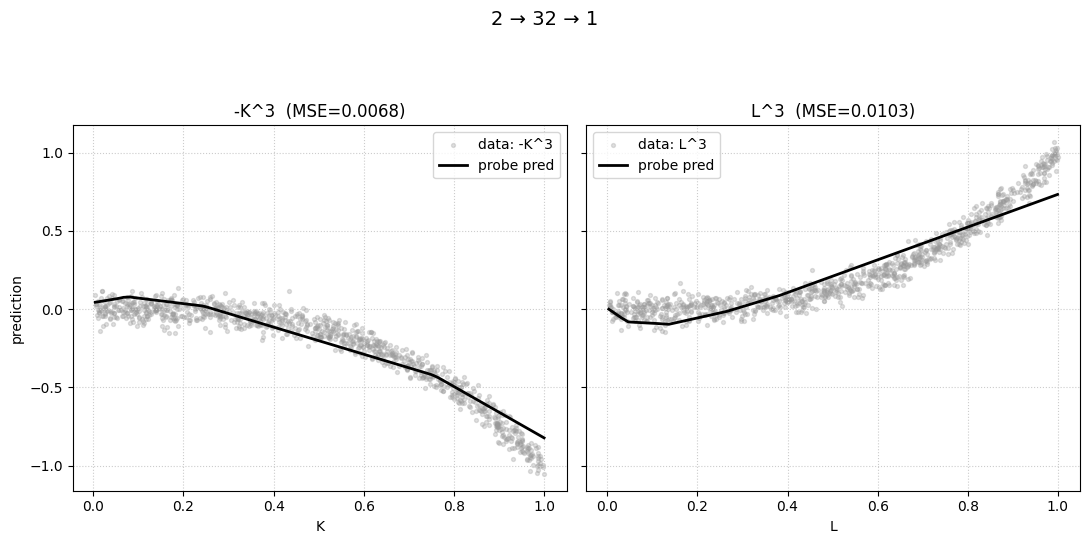


######## Layer: dense8_2 ########
[dense8_2] (2 → 32 → 16 → 1) -K^3 MSE: 0.007473
[dense8_2] (2 → 32 → 16 → 1)  L^3 MSE: 0.008660


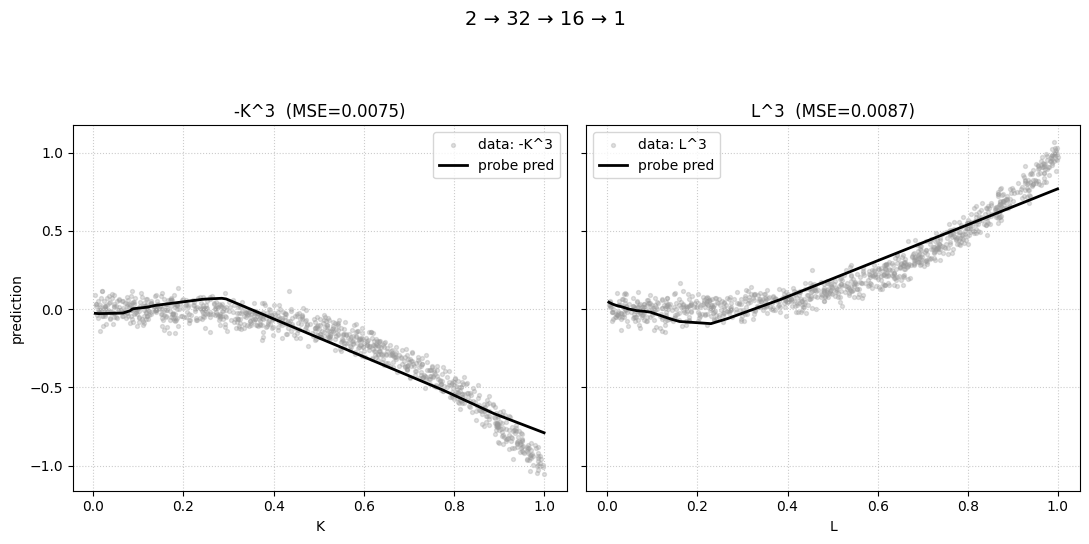


######## Layer: dense8_3 ########
[dense8_3] (2 → 32 → 16 → 8 → 1) -K^3 MSE: 0.004456
[dense8_3] (2 → 32 → 16 → 8 → 1)  L^3 MSE: 0.019725


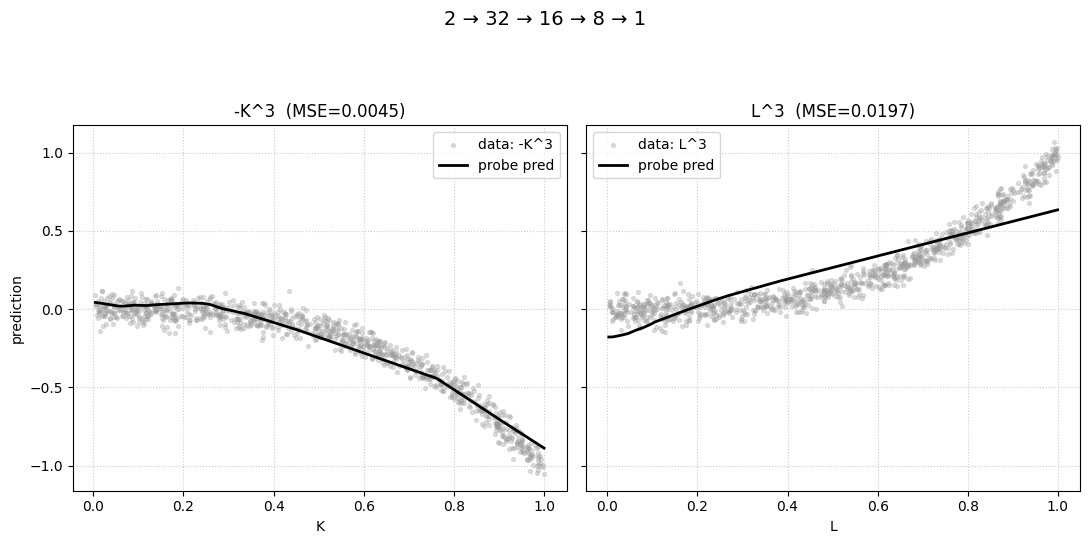


######## Layer: dense8_4 ########
[dense8_4] (2 → 32 → 16 → 8 → 4 → 1) -K^3 MSE: 0.002851
[dense8_4] (2 → 32 → 16 → 8 → 4 → 1)  L^3 MSE: 0.016798


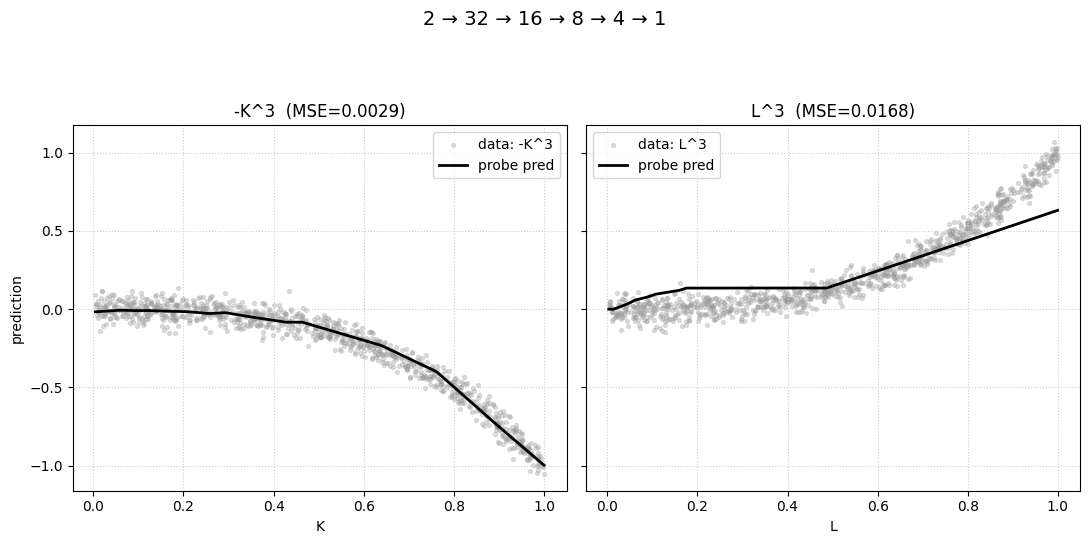

In [2]:
# ======================
# 7. Compare per layer (side-by-side)
# ======================
for lname in layer_names:
    print(f"\n######## Layer: {lname} ########")

    plot_1d_probe_pair(
        model_K      = probes_Kneg[lname],   # -K^3 task
        model_L      = probes_Lcube[lname],  #  L^3 task
        X_K          = X_K,
        y2           = y2,
        order_K      = order_K,
        K_sorted     = K_sorted,
        y2_sorted    = y2_sorted,
        X_L          = X_L,
        y3           = y3,
        order_L      = order_L,
        L_sorted     = L_sorted,
        y3_sorted    = y3_sorted,
        layer_name   = lname,
    )
